In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
book = cv2.imread('./assignment3/book.pgm', cv2.IMREAD_GRAYSCALE)
scene = cv2.imread('./assignment3/scene.pgm', cv2.IMREAD_GRAYSCALE)

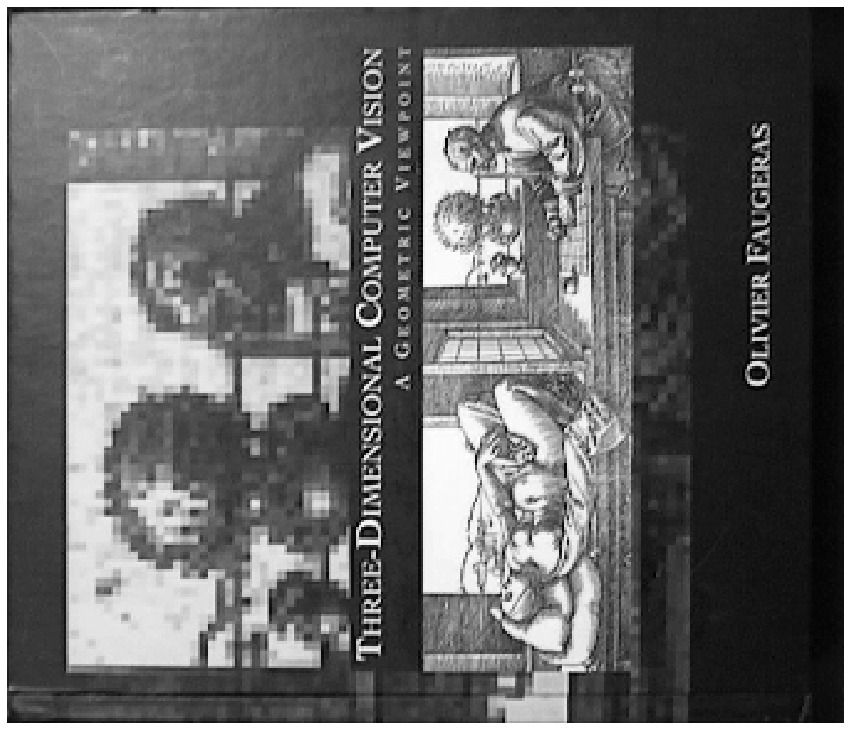

In [3]:
plt.figure(figsize = (15,15))
plt.imshow(book,cmap='gray');
plt.axis('off');

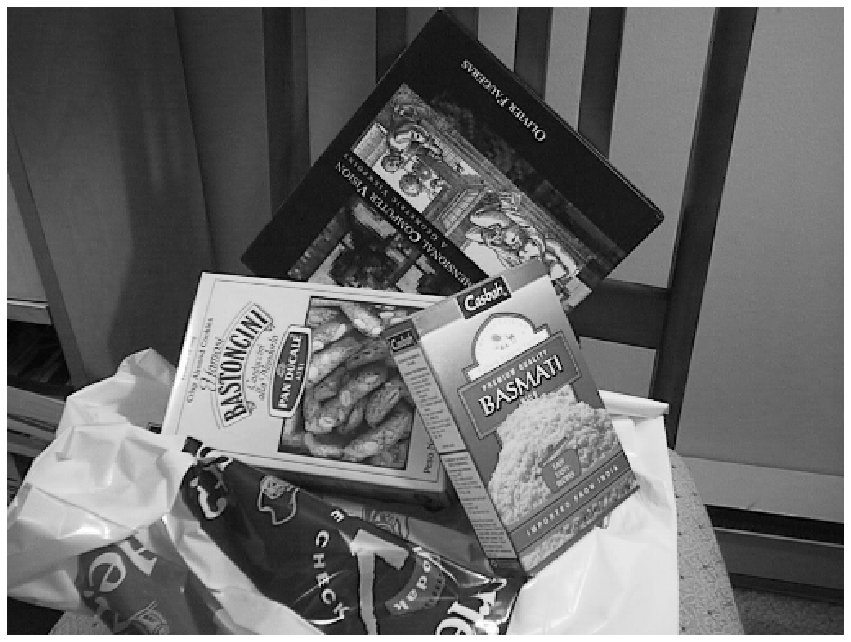

In [4]:
plt.figure(figsize = (15,15))
plt.imshow(scene,cmap='gray');
plt.axis('off');

## SIFT Feature Detector

In [5]:
sift = cv2.SIFT_create()
book_kp,book_des = sift.detectAndCompute(book,None)
scene_kp,scene_des = sift.detectAndCompute(scene,None)

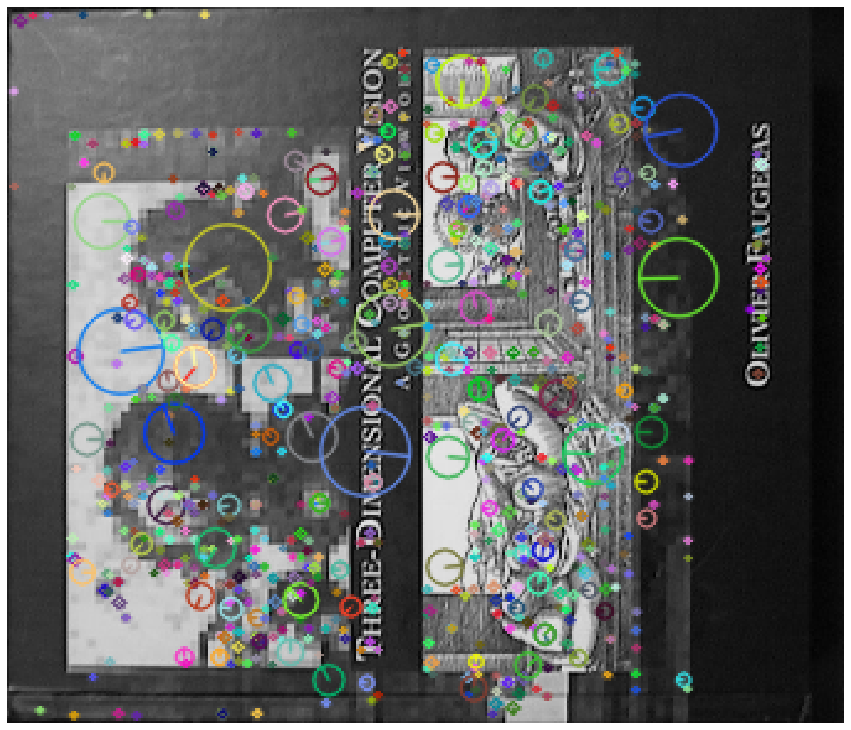

In [6]:
book_draw = cv2.drawKeypoints(book,book_kp,outImage = None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (15,15))
plt.imshow(book_draw,cmap='gray');
plt.axis('off');

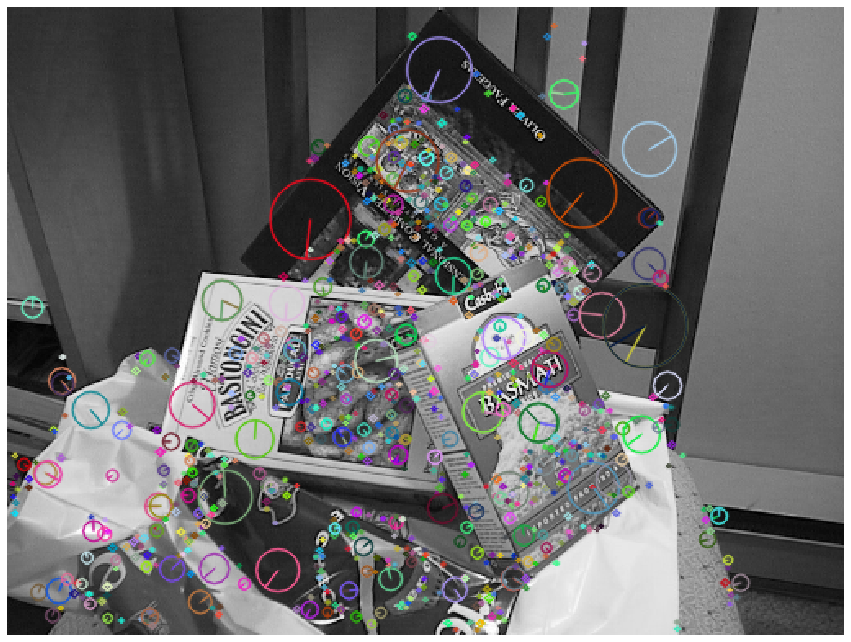

In [7]:
scene_draw = cv2.drawKeypoints(scene,scene_kp,outImage = None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (15,15))
plt.imshow(scene_draw,cmap='gray');
plt.axis('off');

## Closest Neighbor

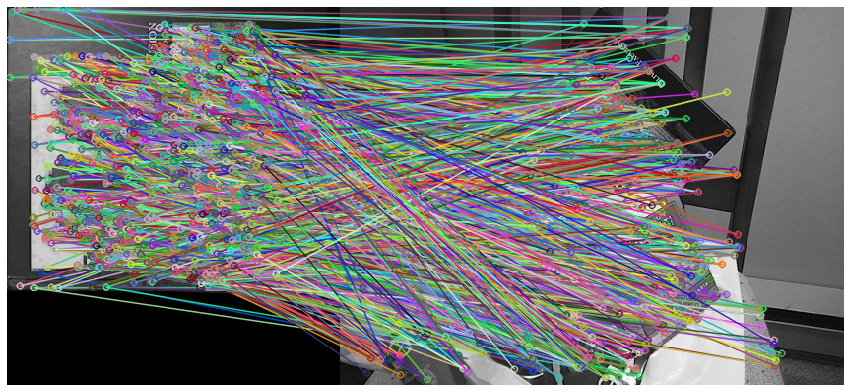

In [8]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(book_des,scene_des, k=2)
matches_img = cv2.drawMatchesKnn(book,book_kp,scene,scene_kp,matches,flags=2,outImg=None)
plt.figure(figsize = (15,15))
plt.imshow(matches_img,cmap='gray');
plt.axis('off');

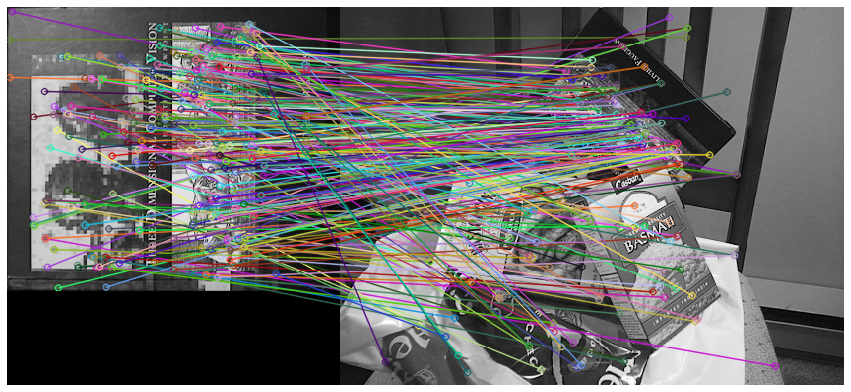

In [9]:
good = []
good_without_list = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append([m])
        good_without_list.append(m)
matches_img = cv2.drawMatchesKnn(book,book_kp,scene,scene_kp,good,flags=2,outImg=None)
plt.figure(figsize = (15,15))
plt.imshow(matches_img,cmap='gray');
plt.axis('off');

In [10]:
src_pts = np.float32([book_kp[m.queryIdx].pt for m in good_without_list])
dst_pts = np.float32([scene_kp[m.trainIdx].pt for m in good_without_list])

## RANSAC

In [11]:
N = 100

max_count = 0
best_inliers = 0
best_q = 0
for i in range(N):
    pick_matches = np.random.choice(range(len(src_pts)), 3)
    A = np.zeros([6,6])
    b = np.zeros([6])
    for j in range(3):
        A[2*j][0] = src_pts[pick_matches[j]][0]
        A[2*j][1] = src_pts[pick_matches[j]][1]
        A[2*j][2] = 1
        A[2*j+1][3] = src_pts[pick_matches[j]][0]
        A[2*j+1][4] = src_pts[pick_matches[j]][1]
        A[2*j+1][5] = 1
        b[2*j] = dst_pts[pick_matches[j]][0]
        b[2*j+1] = dst_pts[pick_matches[j]][1]
    try:
        q = np.linalg.solve(A, b)
    except:
        continue
        
    
    count = 0
    inliers = []
    for j in range(len(src_pts)):
        transform = np.dot(np.array([[src_pts[j][0],src_pts[j][1],1,0,0,0],[0,0,0,src_pts[j][0],src_pts[j][1],1]]),q)
        if np.linalg.norm(transform - dst_pts[j]) < 10:
            count += 1
            inliers.append(good_without_list[j])
    if count>max_count:
        max_count = count
        best_inliers = inliers
        best_q = q
print('max count:',max_count)

max count: 114


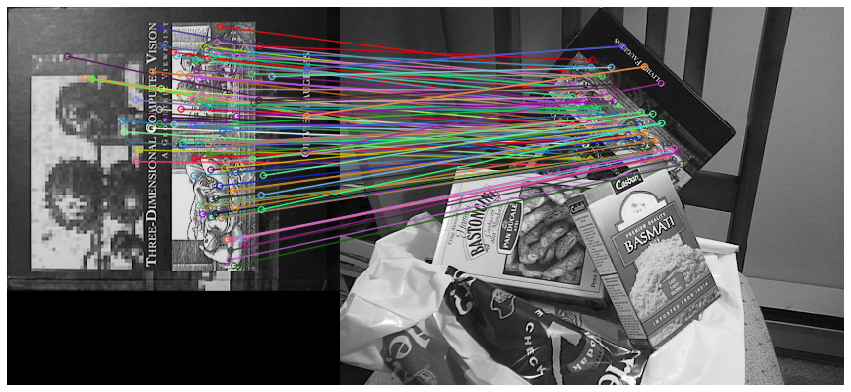

In [12]:
matches_img = cv2.drawMatches(book,book_kp,scene,scene_kp,best_inliers,flags=2,outImg=None)
plt.figure(figsize = (15,15))
plt.imshow(matches_img,cmap='gray');
plt.axis('off');

## Homography Matrix H

In [16]:
H = np.zeros([3,3])
H[0][0] = best_q[0]
H[0][1] = best_q[1]
H[0][2] = best_q[4]
H[1][0] = best_q[2]
H[1][1] = best_q[3]
H[1][2] = best_q[5]
H[2][2] = 1
H

array([[  0.40967485,   0.45021564,   0.42946945],
       [133.71993826,  -0.47768452, 158.69233577],
       [  0.        ,   0.        ,   1.        ]])

In [13]:
H = best_q.reshape(2,3)
H

array([[  0.40967485,   0.45021564, 133.71993826],
       [ -0.47768452,   0.42946945, 158.69233577]])

## Alignment Result

In [14]:
result = cv2.warpAffine(book, best_q.reshape(2,3),(scene.shape[1],scene.shape[0]))

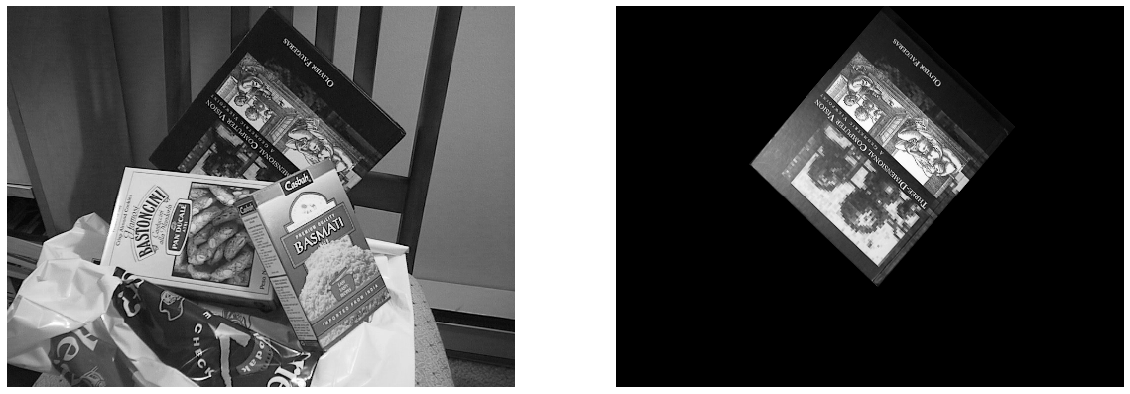

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(scene,cmap='gray');
axs[0].axis('off');
axs[1].imshow(result,cmap='gray');
axs[1].axis('off');